# 0.0 Imports

In [1]:
import pandas             as pd
import numpy              as np
#import xgboost            as xgb
import scikitplot         as skplt

import matplotlib.pyplot  as plt
import seaborn            as sns

from IPython.display         import Image
from scipy                   import stats            as ss
from sklearn                 import preprocessing    as pp
from sklearn                 import model_selection  as ms
from sklearn                 import ensemble         as en
from sklearn                 import metrics          as m
from scikitplot              import metrics          as mt
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.ensemble     import RandomForestClassifier
#from boruta               import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn              import svm
#from lightgbm             import LGBMClassifier
from sklearn.naive_bayes  import GaussianNB
#from skopt                import forest_minimize
#from skopt.plots          import plot_convergence
from flask                import Flask, request, Response

import warnings
import pickle
import inflection
warnings.filterwarnings("ignore")

%matplotlib inline

## 0.1 Helper Functions

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v   

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

## 0.2 Loading Data

In [3]:
data_kaggle = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/dataset_kaggle_block_fraud_company.csv')

In [4]:
data_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
data_kaggle['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

- Memory usage is too high (500MB+), there are many data to manipulate in a local machine. A split strategy will be applied to split data for less memory use

### 0.2.1 Data split 

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_1_index, train_2_index in split.split(data_kaggle, data_kaggle['isFraud']):
    strat_train_1_set = data_kaggle.loc[train_1_index]
    strat_train_2_set = data_kaggle.loc[train_2_index]

In [7]:
strat_train_2_set.to_csv('C:/Users/Guilherme/Repos/Dataset pa002/dataset_sampled.csv', index=False)
strat_train_2_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272524 entries, 4051353 to 2496743
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1272524 non-null  int64  
 1   type            1272524 non-null  object 
 2   amount          1272524 non-null  float64
 3   nameOrig        1272524 non-null  object 
 4   oldbalanceOrg   1272524 non-null  float64
 5   newbalanceOrig  1272524 non-null  float64
 6   nameDest        1272524 non-null  object 
 7   oldbalanceDest  1272524 non-null  float64
 8   newbalanceDest  1272524 non-null  float64
 9   isFraud         1272524 non-null  int64  
 10  isFlaggedFraud  1272524 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 116.5+ MB


- Now memory is 116 MB of usage, more acceptable to use in a local machine to manipulate data and process it.

### 0.2.1 Loading splited data

In [8]:
data_splited = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/dataset_sampled.csv')

#### 0.2.1.1 Slipt data in dataset (train and validation) and test

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test_1_index, test_2_index in split.split(data_splited, data_splited['isFraud']):
    dataset = data_splited.loc[test_1_index]
    dataset_test = data_splited.loc[test_2_index]

In [10]:
dataset['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [11]:
dataset_test['isFraud'].value_counts(normalize=True)

0    0.998707
1    0.001293
Name: isFraud, dtype: float64

# 1.0 Data Description

In [12]:
df1 = dataset.copy()

## 1.1 Rename Columns

In [13]:
cols_old = df1.columns
cols_old

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [14]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [15]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.2 Data Dimension

In [16]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1018019
Number of Columns: 11


## 1.3 Data Types

In [17]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

- It is not necessary to change data types.

## 1.4 Check NAN

In [18]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

- There is no NAN in original datas

## 1.5 Fillout NA

- Not necessary, as seen in 1.4 section

## 1.6 Columns Description

In [19]:
cols = df1.columns
cols

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

- **step**: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).


- **type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.


- **amount**: amount of the transaction in local currency.


- **nameOrig**: customer who started the transaction


- **oldbalanceOrg**: initial balance before the transaction


- **newbalanceOrig**: new balance after the transaction


- **nameDest**: customer who is the recipient of the transaction


- **oldbalanceDest**: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).


- **newbalanceDest**: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).


- **isFraud**: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.


- **isFlaggedFraud**: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 1.7 Descriptive Statistical

In [20]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

In [21]:
num_attributes = df1[['step', 'amount', 'oldbalance_org', 'newbalance_orig','oldbalance_dest','newbalance_dest']]

cat_attributes = df1[['type', 'name_orig', 'name_dest', 'is_flagged_fraud' ]]

target_atribute = df1['is_fraud']

### 1.7.1 Numerical Attributes

In [22]:
# Central Tendency - Mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max()- x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate

m1 = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,7.430000e+02,7.420000e+02,2.436658e+02,240.00,1.422949e+02,0.373599,0.331036
1,amount,0.0,7.382349e+07,7.382349e+07,1.795085e+05,75084.58,6.095758e+05,34.118907,2217.482761
2,oldbalance_org,0.0,4.368662e+07,4.368662e+07,8.359437e+05,14286.00,2.894280e+06,5.246317,32.851252
3,newbalance_orig,0.0,4.367380e+07,4.367380e+07,8.572754e+05,0.00,2.930012e+06,5.175640,32.003068
4,oldbalance_dest,0.0,3.279630e+08,3.279630e+08,1.101495e+06,132412.14,3.411120e+06,19.893070,949.399393
5,newbalance_dest,0.0,3.281945e+08,3.281945e+08,1.225370e+06,213340.26,3.698582e+06,19.844348,908.619602


### 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type                      5
name_orig           1017767
name_dest            657058
is_flagged_fraud          1
dtype: int64

<AxesSubplot:xlabel='type', ylabel='count'>

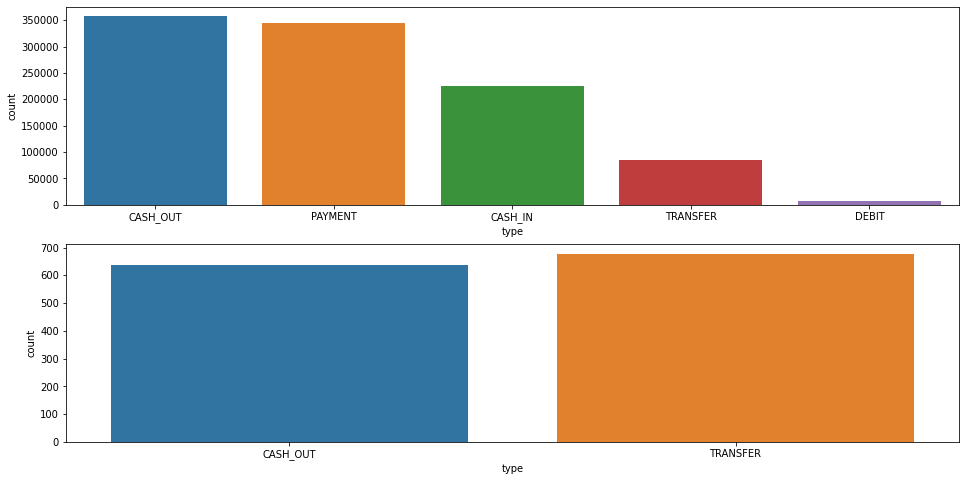

In [24]:
fig, axs = plt.subplots( nrows = 2,  figsize = (16,8))

sns.countplot(x ='type', data= df1[df1['is_fraud']==0], ax=axs[0])

sns.countplot(x ='type', data= df1[df1['is_fraud']==1], ax=axs[1])

In [25]:
df1[df1['is_fraud']==1]['name_orig'].value_counts()

C282621115     1
C29170093      1
C161612692     1
C1703895485    1
C522387015     1
              ..
C1379900917    1
C31495948      1
C937991476     1
C1003023037    1
C480126375     1
Name: name_orig, Length: 1314, dtype: int64

<AxesSubplot:xlabel='name_orig', ylabel='Density'>

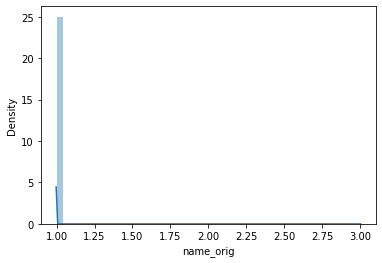

In [26]:
sns.distplot(cat_attributes['name_orig'].value_counts())

In [27]:
df1[df1['is_fraud']==1]['name_dest'].value_counts()

C644163395     2
C105660024     2
C790415785     1
C881927745     1
C1540448785    1
              ..
C1508064575    1
C1004490006    1
C1528787754    1
C822023370     1
C1717483604    1
Name: name_dest, Length: 1312, dtype: int64

<AxesSubplot:xlabel='name_dest'>

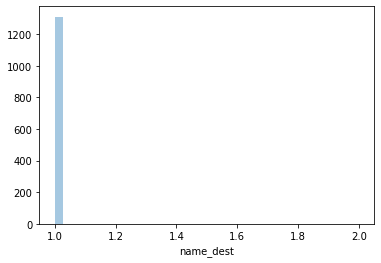

In [28]:
sns.distplot(df1[df1['is_fraud']==1]['name_dest'].value_counts(), kde = False)

In [29]:
target_atribute.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: is_fraud, dtype: float64

**Data Description Summary:**

1. **XXX** 
    - Range is from 20 to 85. 
    - Mean is 38.82 and median is 36. 
    - Higher density is from 20 to 29 with 42%, followed by 40 to 49 with 19,9%.
****    


## 1.8 Save dataset

In [30]:
df1.to_csv('C:/Users/Guilherme/Repos/Dataset pa002/df1.csv', index=False)

# 2.0 Feature Engineering And Variables Filtering

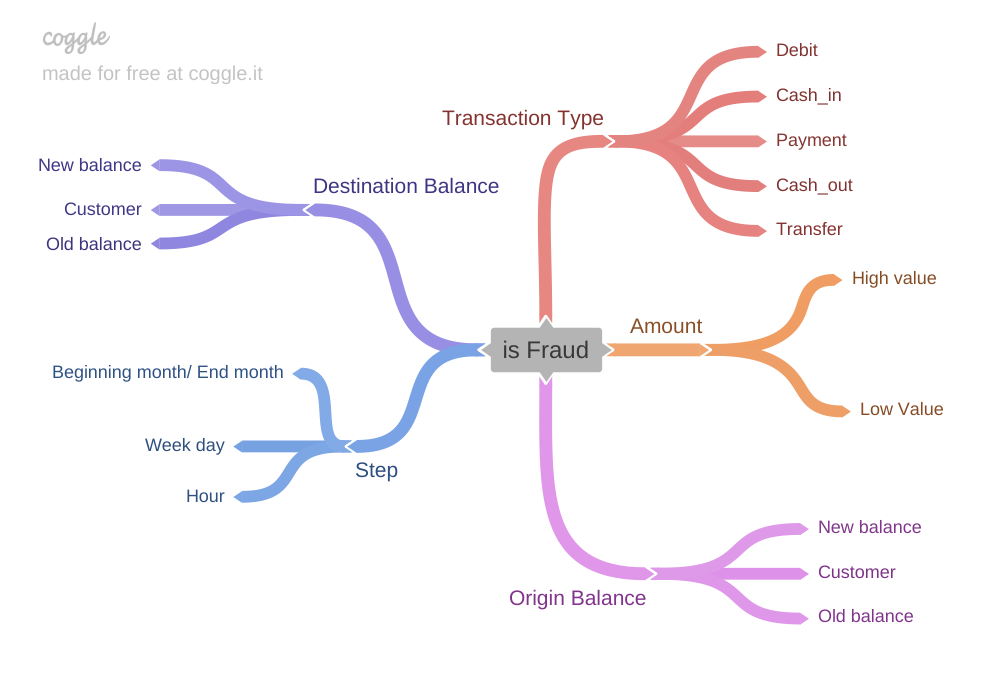

In [31]:
Image ('C:/Users/Guilherme/Repos/pa002_block_fraud_company/images/is_Fraud.png')

## 2.1 Hypotheses creation

### 2.1.1 Amount Hypotheses

 **1.** Fraud should occur in higher value amounts (higher than 200k)
 
 **2.** Fraud should occur in higher percent amount per origin balance (higher than 75%)
 
****

### 2.1.2 Transaction Type Hypotheses

 **1.** Fraud should occur in payment type of transaction
 
 **2.** Fraud should not occur in debit type of transaction
 
****

### 2.1.3 Origin Balance Hypotheses

 **1.** Fraud should occur when the difference between old balance and new balance is lower than amount
 
 **2.** Fraud should not occur when the difference between old balance and new balance is equal to amount
 
 **3.** Fraud should not occur when new balance is equal to 0
 
****

### 2.1.4 Destination Balance Hypotheses

 **1.** Fraud should occur when the difference between new balance and old balance is lower than amount
 
 **2.** Fraud should not occur when the difference between new balance and old balance is equal to amount
 
 **3.** Fraud should not occur when destination is merchant
 
 **4.** Fraud should occur with destination that receive with more frequency
 
****

### 2.1.5 Step Hypotheses

 **1.** Fraud should occur in the beginning of the month (day 1 to day 8)
 
 **2.** Fraud should occurs in weekends
 
 **3.** Fraud should occurs during night (6pm to 10pm)
 
****

## 2.2 Creating New Features

In [32]:
df2 = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/df1.csv')

In [33]:
#step features

#hour
df2['hour'] = df2['step'].apply( lambda x: x % 24 )


#day
df2['day'] = df2['step'].apply( lambda x: np.ceil(x / 24) )


#difference between old and new balance origin
df2['diff_orig'] = df2['oldbalance_org'] - df2['newbalance_orig']

#difference between new and old balance destination
df2['diff_dest'] = df2['newbalance_dest'] - df2['oldbalance_dest']

#merchant destination flag
df2['merchant_dest'] = df2.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)

## 2.3 Variable Filtering

<AxesSubplot:xlabel='newbalance_dest'>

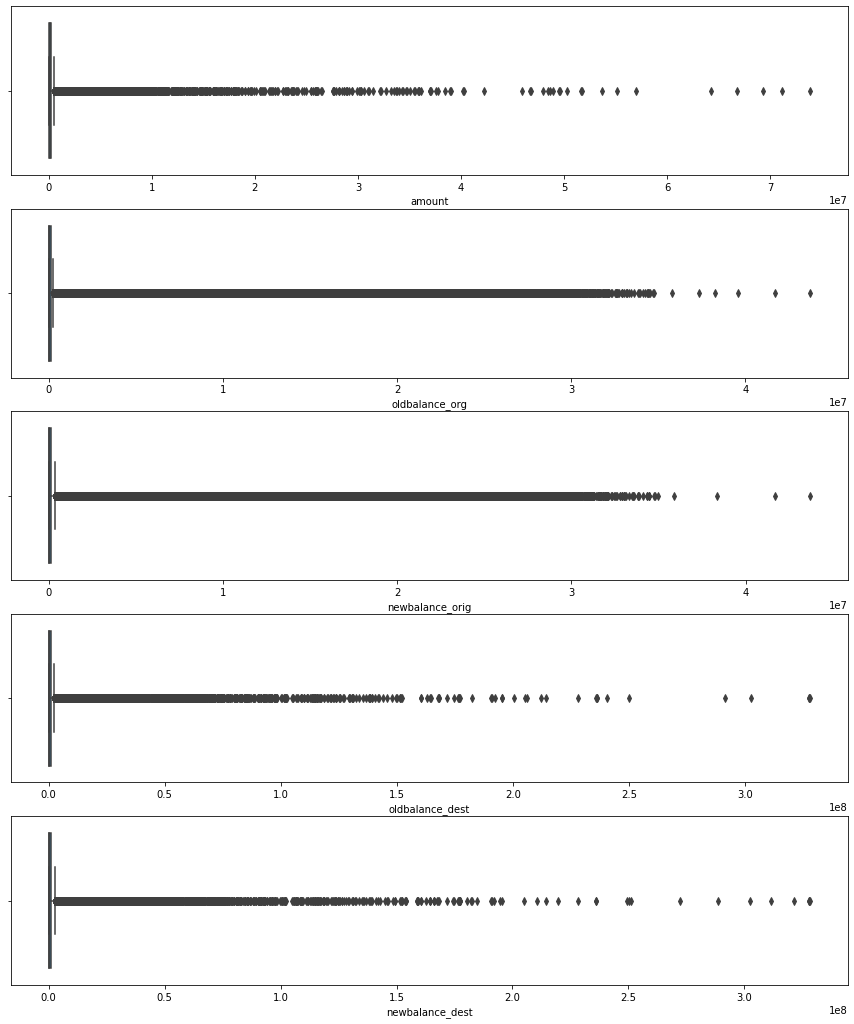

In [34]:
fig, axs = plt.subplots(nrows = 5, figsize = (15,18))
sns.boxplot(df2['amount'], ax=axs[0])
sns.boxplot(df2['oldbalance_org'], ax=axs[1])
sns.boxplot(df2['newbalance_orig'], ax=axs[2])
sns.boxplot(df2['oldbalance_dest'], ax=axs[3])
sns.boxplot(df2['newbalance_dest'], ax=axs[4])

In [35]:
df2 = df2[df2['amount'] < 4e7]
df2 = df2[df2['oldbalance_org'] < 4e7]
df2 = df2[df2['newbalance_orig'] < 4e7]
df2 = df2[df2['oldbalance_dest'] < 2e8]
df2 = df2[df2['newbalance_dest'] < 2e8]

<AxesSubplot:xlabel='newbalance_dest'>

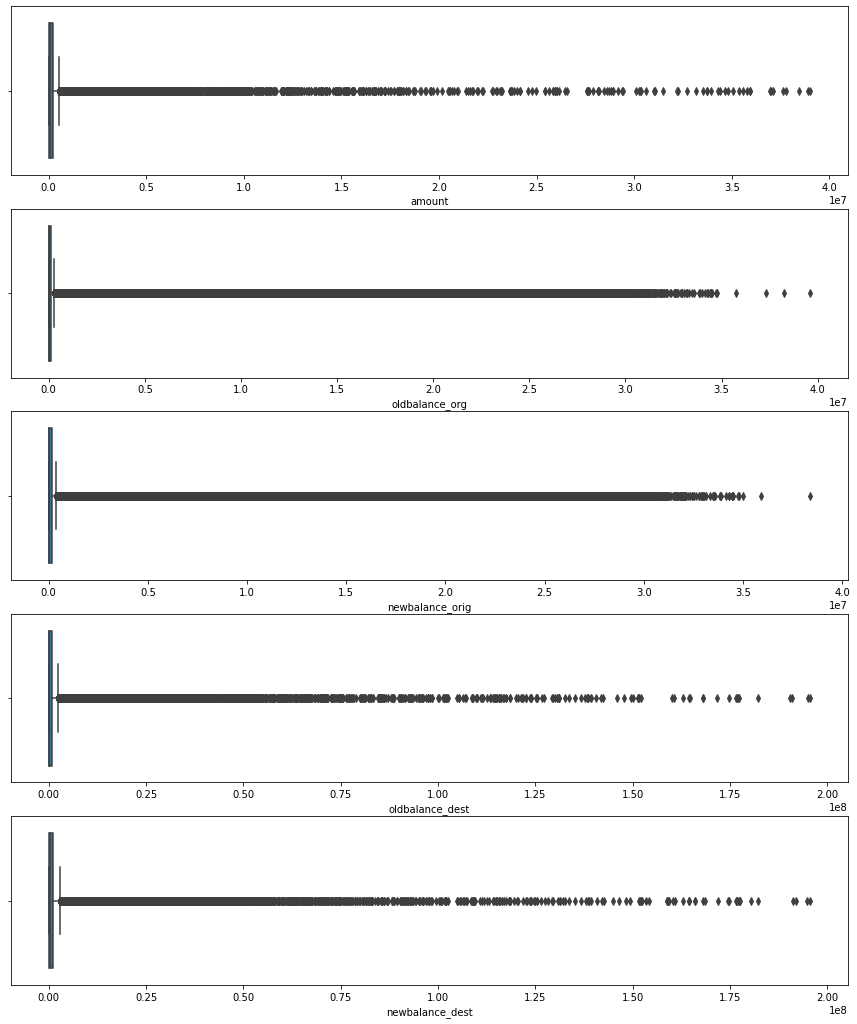

In [36]:
fig, axs = plt.subplots(nrows = 5, figsize = (15,18))
sns.boxplot(df2['amount'], ax=axs[0])
sns.boxplot(df2['oldbalance_org'], ax=axs[1])
sns.boxplot(df2['newbalance_orig'], ax=axs[2])
sns.boxplot(df2['oldbalance_dest'], ax=axs[3])
sns.boxplot(df2['newbalance_dest'], ax=axs[4])

## 2.4 Save dataset

In [37]:
df2.to_csv('C:/Users/Guilherme/Repos/Dataset pa002/df2.csv', index=False)

# 3.0 Exploratory Data Analysis (EDA)

In [38]:
df3 = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/df2.csv')

## 3.1 Univariate Analysis

In [39]:
df3.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'hour', 'day', 'diff_orig', 'diff_dest',
       'merchant_dest'],
      dtype='object')

### 3.1.1 Numerical variables

#### 3.1.1.1 Step analysis

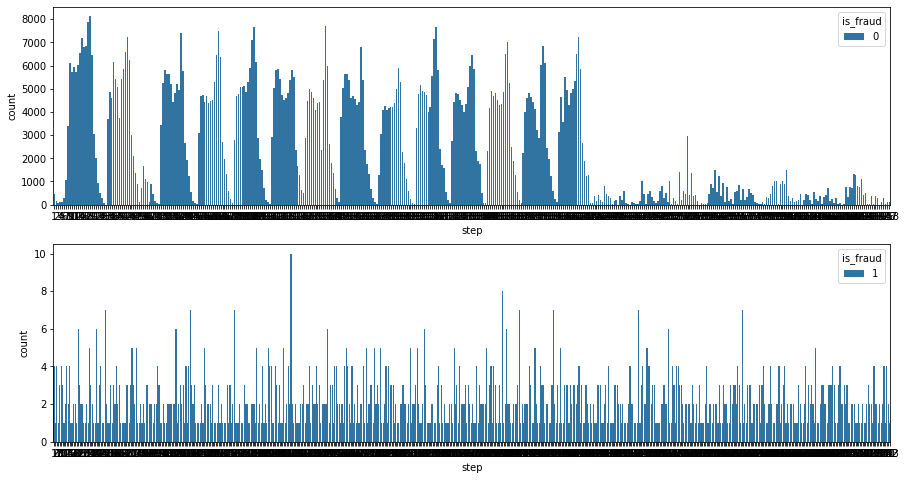

In [40]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'step', data=df3[df3['is_fraud']==0], hue='is_fraud',ax=axs[0]);
sns.countplot(x = 'step', data=df3[df3['is_fraud']==1], hue='is_fraud',ax=axs[1]);

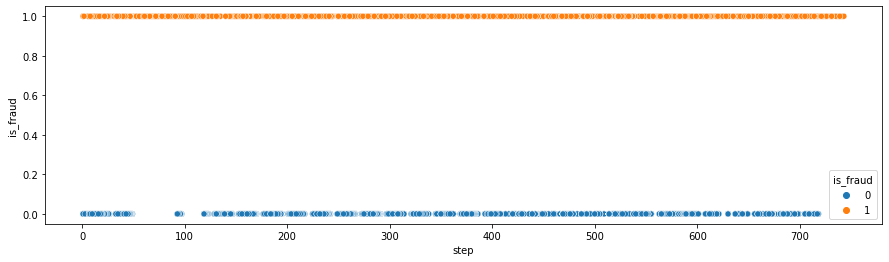

In [41]:
fig = plt.subplots( figsize = (15,4))
sns.scatterplot(x = 'step', data=df3, y='is_fraud', hue = 'is_fraud');

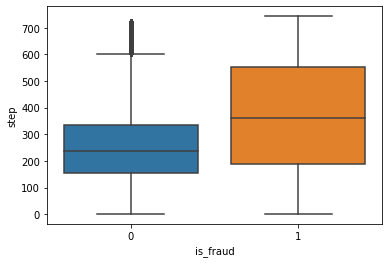

In [42]:
sns.boxplot(x= 'is_fraud', y='step', data=df3);

#### 3.1.1.2 Day analysis

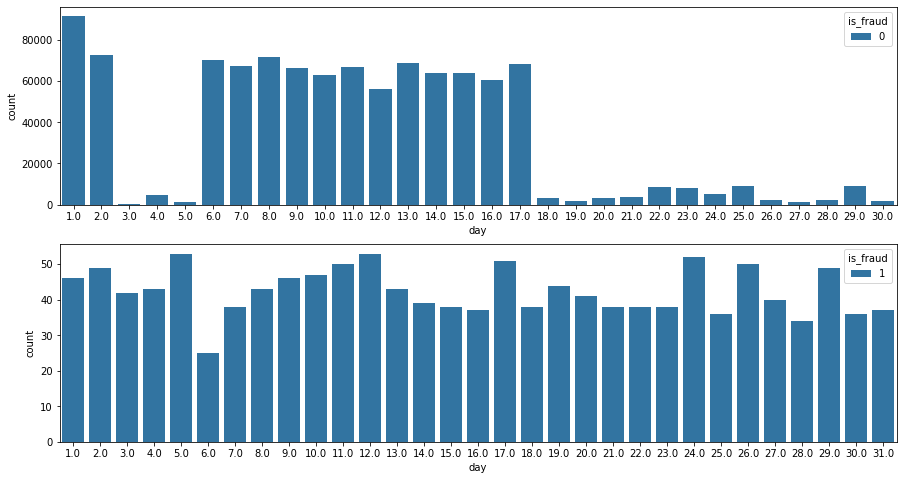

In [43]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'day', data=df3[df3['is_fraud']==0], hue='is_fraud',ax=axs[0]);
sns.countplot(x = 'day', data=df3[df3['is_fraud']==1], hue='is_fraud',ax=axs[1]);

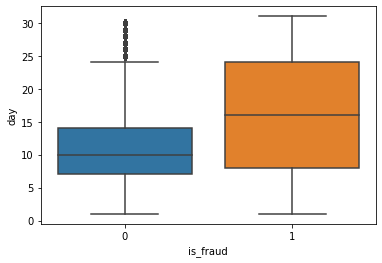

In [44]:
sns.boxplot(x= 'is_fraud', y='day', data=df3);

#### 3.1.1.3 Hour analysis

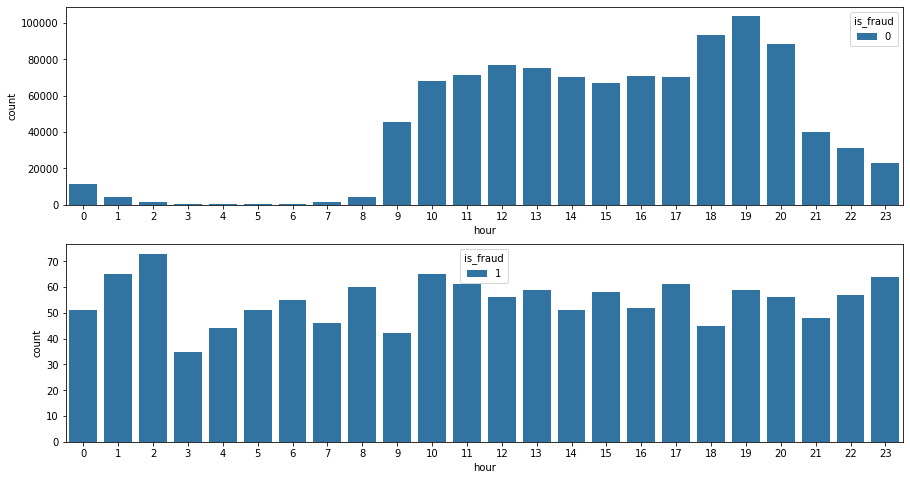

In [45]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'hour', data=df3[df3['is_fraud']==0], hue='is_fraud',ax=axs[0]);
sns.countplot(x = 'hour', data=df3[df3['is_fraud']==1], hue='is_fraud',ax=axs[1]);

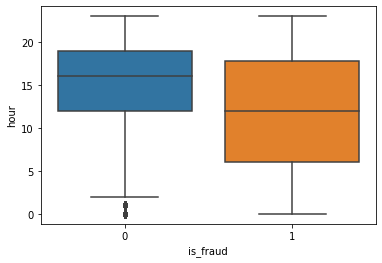

In [46]:
sns.boxplot(x= 'is_fraud', y='hour', data=df3);

#### 3.1.1.4 Amount analysis

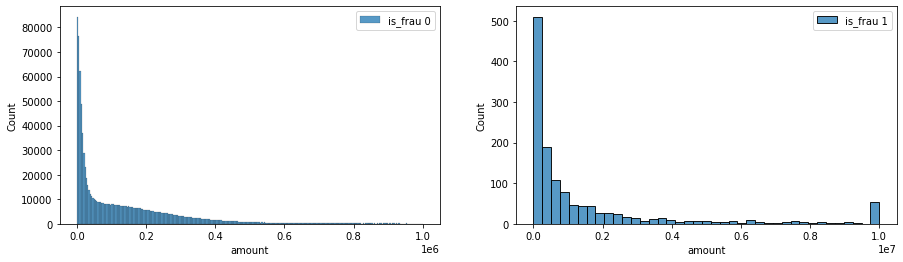

In [47]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['amount']< 1e6)]['amount'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[df3['is_fraud']== 1]['amount'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

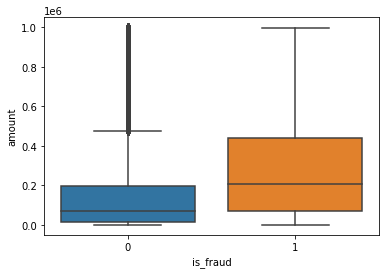

In [48]:
sns.boxplot(x= 'is_fraud', y='amount', data=df3[df3['amount']< 1e6]);

#### 3.1.1.5 Old balance origin analysis

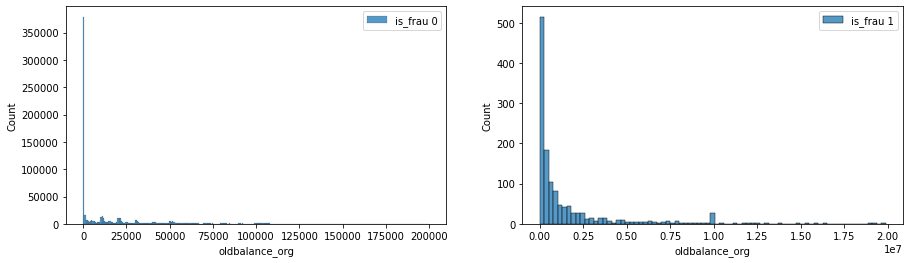

In [49]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['oldbalance_org']< 2e5)]['oldbalance_org'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[(df3['is_fraud']== 1) & (df3['oldbalance_org']< 2e7)]['oldbalance_org'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

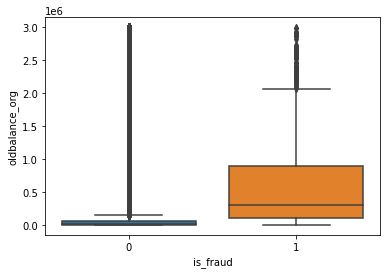

In [50]:
sns.boxplot(x= 'is_fraud', y='oldbalance_org', data=df3[df3['oldbalance_org']< 3e6]);

#### 3.1.1.6 New balance origin analysis

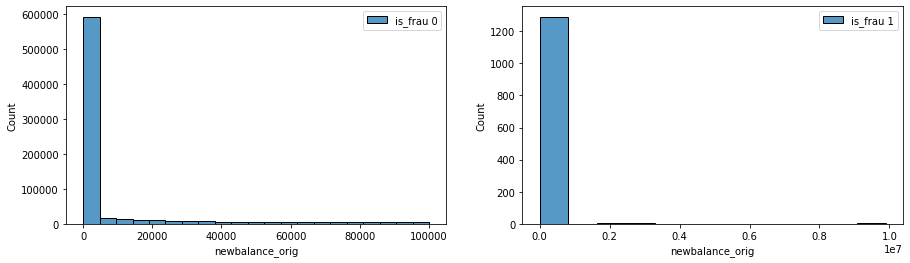

In [51]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['newbalance_orig']< 1e5)]['newbalance_orig'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[(df3['is_fraud']== 1) & (df3['newbalance_orig']< 1e7)]['newbalance_orig'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

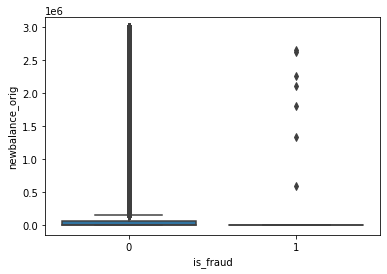

In [52]:
sns.boxplot(x= 'is_fraud', y='newbalance_orig', data=df3[df3['newbalance_orig']< 3e6]);

#### 3.1.1.7 Difference balance origin analysis

<AxesSubplot:xlabel='day', ylabel='diff_orig'>

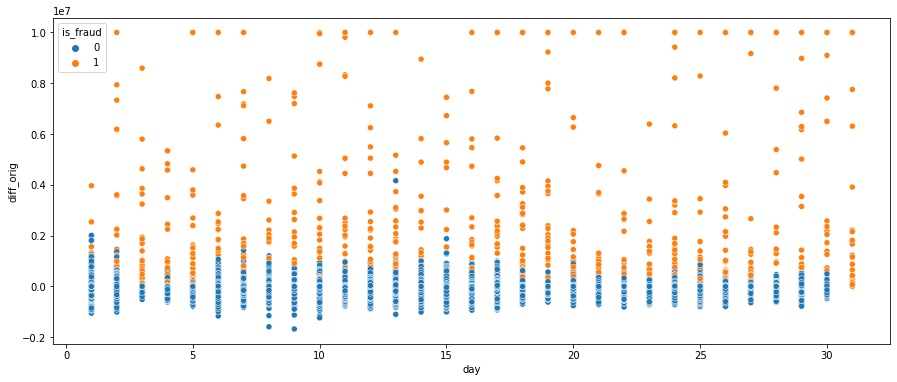

In [53]:
plt.subplots(figsize=(15,6))
sns.scatterplot(x='day', y='diff_orig', hue='is_fraud', data=df3)

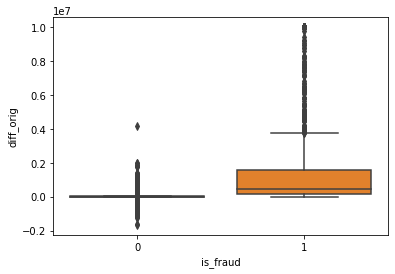

In [54]:
sns.boxplot(x= 'is_fraud', y='diff_orig', data=df3);

#### 3.1.1.8 Old balance destination analysis

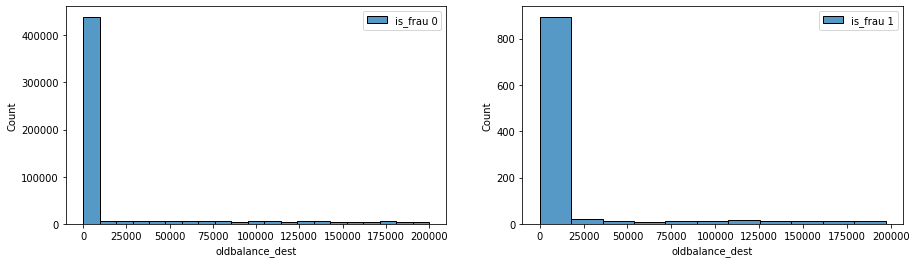

In [55]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['oldbalance_dest']< 2e5)]['oldbalance_dest'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[(df3['is_fraud']== 1) & (df3['oldbalance_dest']< 2e5)]['oldbalance_dest'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

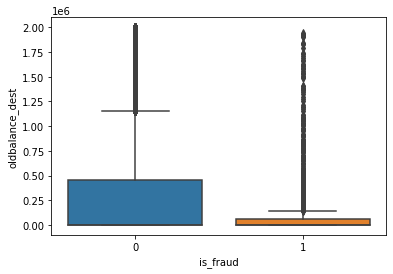

In [56]:
sns.boxplot(x= 'is_fraud', y='oldbalance_dest', data=df3[df3['oldbalance_dest']< 2e6]);

#### 3.1.1.9 New balance destination analysis

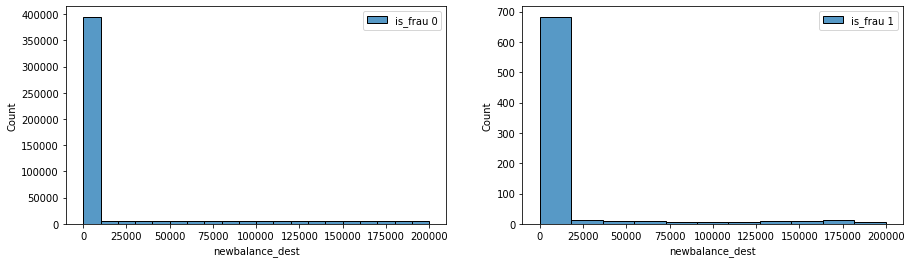

In [57]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['newbalance_dest']< 2e5)]['newbalance_dest'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[(df3['is_fraud']== 1) & (df3['newbalance_dest']< 2e5)]['newbalance_dest'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

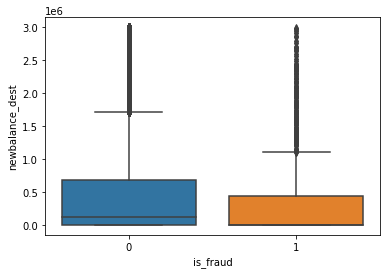

In [58]:
sns.boxplot(x= 'is_fraud', y='newbalance_dest', data=df3[df3['newbalance_dest']< 3e6]);

#### 3.1.1.10 Difference balance destination analysis

<AxesSubplot:xlabel='amount', ylabel='diff_dest'>

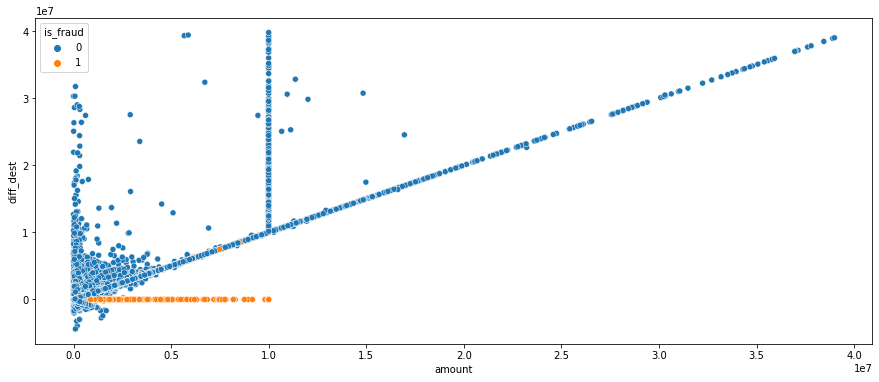

In [59]:
plt.subplots(figsize=(15,6))
sns.scatterplot(x='amount', y='diff_dest', hue='is_fraud', data=df3[(df3['amount']< 8e7) & (df3['diff_dest']< 4e7)])

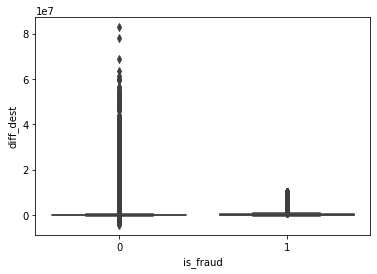

In [60]:
sns.boxplot(x= 'is_fraud', y='diff_dest', data=df3);

### 3.1.2 Categorical variables

#### 3.1.2.1 Transaction type analysis

<AxesSubplot:xlabel='type', ylabel='count'>

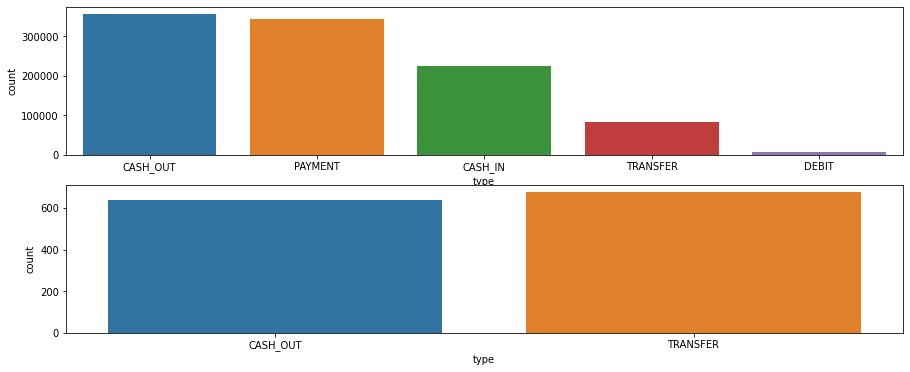

In [61]:
fig, axs = plt.subplots( nrows = 2,  figsize = (15,6))
sns.countplot(x ='type', data= df3[df3['is_fraud']==0], ax=axs[0])
sns.countplot(x ='type', data= df3[df3['is_fraud']==1], ax=axs[1])

<AxesSubplot:xlabel='amount', ylabel='diff_orig'>

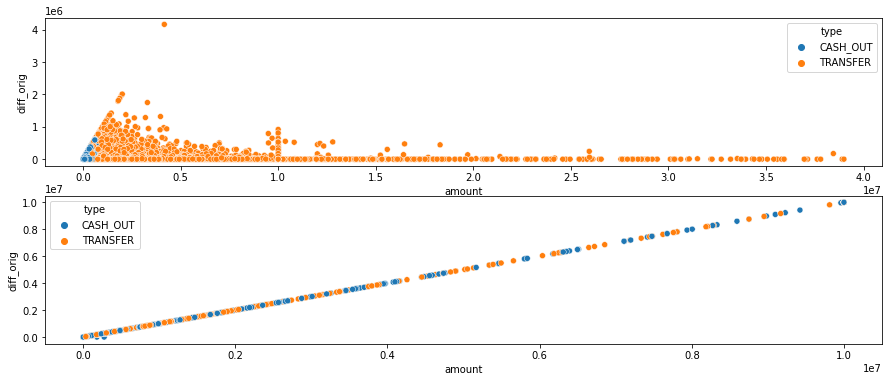

In [62]:
aux1 = df3[((df3['type']=='CASH_OUT') | (df3['type']=='TRANSFER')) & (df3['is_fraud']==0)]
aux2 = df3[((df3['type']=='CASH_OUT') | (df3['type']=='TRANSFER')) & (df3['is_fraud']==1)]
fig, axs = plt.subplots( nrows = 2,  figsize = (15,6))
sns.scatterplot(x='amount', y='diff_orig', hue='type', data=aux1, ax=axs[0])
sns.scatterplot(x='amount', y='diff_orig', hue='type', data=aux2, ax=axs[1])

<AxesSubplot:xlabel='amount', ylabel='diff_orig'>

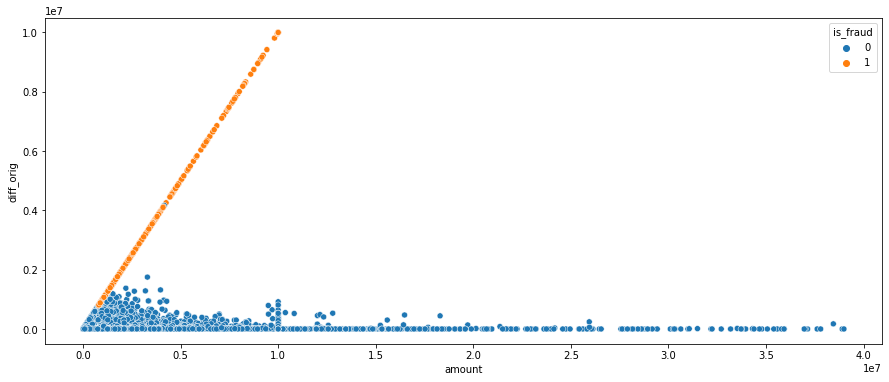

In [63]:
fig = plt.subplots( figsize = (15,6))
aux3 = df3[((df3['type']=='CASH_OUT') | (df3['type']=='TRANSFER'))]
sns.scatterplot(x='amount', y='diff_orig', hue='is_fraud', data=aux3)

#### 3.1.2.2 Name origin analysis

In [64]:
df3[df3['is_fraud']==1]['name_orig'].value_counts()

C282621115     1
C29170093      1
C161612692     1
C1703895485    1
C522387015     1
              ..
C1379900917    1
C31495948      1
C937991476     1
C1003023037    1
C480126375     1
Name: name_orig, Length: 1314, dtype: int64

In [65]:
df3[df3['is_fraud']==0]['name_orig'].value_counts()

C1677795071    3
C289747701     2
C498805746     2
C1863822995    2
C494189913     2
              ..
C15298088      1
C1656132633    1
C1241189079    1
C392760422     1
C1378662254    1
Name: name_orig, Length: 1016416, dtype: int64

#### 3.1.2.3 Name destination analysis

In [66]:
df3[df3['is_fraud']==1]['name_dest'].value_counts()

C644163395     2
C105660024     2
C790415785     1
C881927745     1
C1540448785    1
              ..
C1508064575    1
C1004490006    1
C1528787754    1
C822023370     1
C1717483604    1
Name: name_dest, Length: 1312, dtype: int64

In [67]:
df3[(df3['is_fraud']==1)&(df3['name_dest'].str.startswith('M'))]['name_dest'].value_counts()

Series([], Name: name_dest, dtype: int64)

In [68]:
df3[df3['is_fraud']==0]['name_dest'].value_counts()

C1262822392    23
C248609774     23
C1286084959    21
C1721246982    21
C451111351     21
               ..
C305344403      1
M526769271      1
M1261250888     1
C951681342      1
C196482118      1
Name: name_dest, Length: 656298, dtype: int64

In [69]:
df3[(df3['is_fraud']==0)&(df3['name_dest'].str.startswith('M'))]['name_dest'].value_counts()

M837195085     2
M1007856222    2
M197143491     2
M1820018290    2
M1193574469    2
              ..
M990534019     1
M840150377     1
M336516138     1
M1360686795    1
M404417533     1
Name: name_dest, Length: 344030, dtype: int64

#### 3.1.2.4 Is flagged fraud analysis

In [70]:
df3['is_flagged_fraud'].value_counts()

0    1017980
Name: is_flagged_fraud, dtype: int64

#### 3.1.2.5 Merchant destination analysis

<AxesSubplot:xlabel='merchant_dest', ylabel='count'>

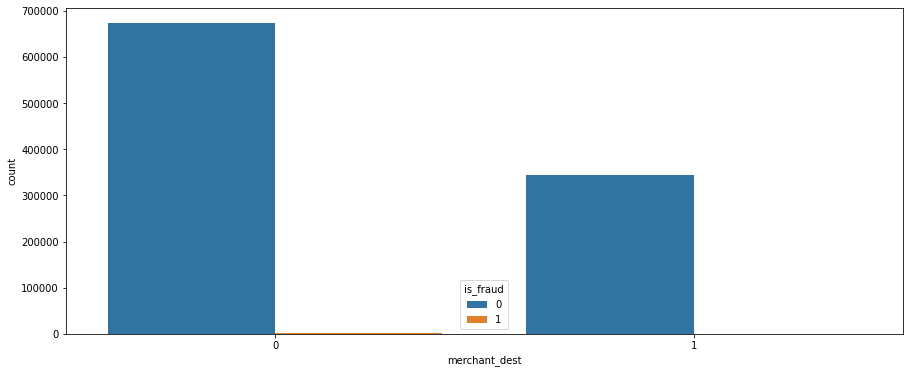

In [71]:
fig = plt.subplots(  figsize = (15,6))
sns.countplot(x ='merchant_dest', data= df3, hue = 'is_fraud')

In [72]:
df3['merchant_dest'].value_counts()

0    673922
1    344058
Name: merchant_dest, dtype: int64

In [73]:
df3[(df3['is_fraud']==0)]['merchant_dest'].value_counts()

0    672608
1    344058
Name: merchant_dest, dtype: int64

In [74]:
df3[(df3['is_fraud']==1)]['merchant_dest'].value_counts()

0    1314
Name: merchant_dest, dtype: int64

### 3.1.3 Target variable

<AxesSubplot:xlabel='is_fraud', ylabel='count'>

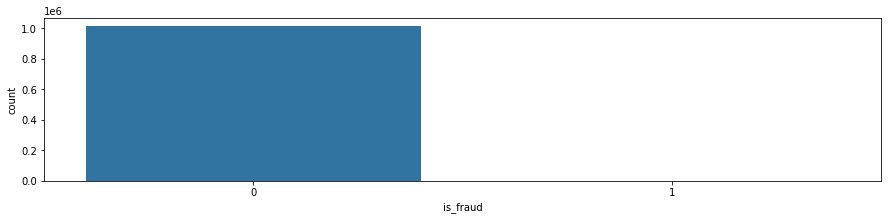

In [75]:
fig = plt.subplots(  figsize = (15,3))
sns.countplot(x ='is_fraud', data= df3)

In [76]:
df3['is_fraud'].value_counts()

0    1016666
1       1314
Name: is_fraud, dtype: int64

In [77]:
df3['is_fraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: is_fraud, dtype: float64

## 3.2 Bivariate Analysis

### 3.2.1 Fraud should occur in higher value amounts (higher than 200k)

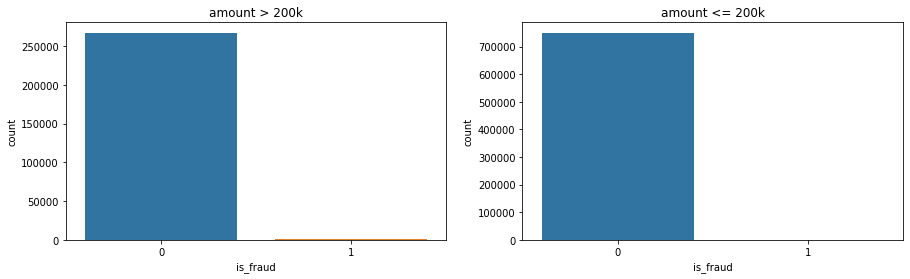

In [78]:
aux1 = df3[df3['amount']>2e5][['step','is_fraud']]
aux2 = df3[df3['amount']<=2e5][['step','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux1['is_fraud'], ax=axs[0]).set_title('amount > 200k')
sns.countplot(aux2['is_fraud'], ax=axs[1]).set_title('amount <= 200k');

In [79]:
aux1['is_fraud'].value_counts()

0    267074
1       886
Name: is_fraud, dtype: int64

In [80]:
aux2['is_fraud'].value_counts()

0    749592
1       428
Name: is_fraud, dtype: int64

In [81]:
aux3 = df3[['amount','is_fraud']]
aux3['amount_200'] = aux3['amount'].apply(lambda x: 1 if x > 2e5 else 0)
aux3 = pd.crosstab(aux3['amount_200'], aux3['is_fraud'])
aux3['percent %'] = aux3[1]*100/(aux3[1]+aux3[0])
aux3

is_fraud,0,1,percent %
amount_200,,,
0,749592,428,0.057065
1,267074,886,0.330646


Hypothesis **TRUE**
- 0.057% of amount <= 200k is a fraud transaction 
- 0.331% of amount > 200k is a fraud transaction 

### 3.2.2 Fraud should occur in higher percent amount per origin balance (higher than 75%)

In [82]:
aux4 = df3.copy()
aux4['amount_per_oldbalance_org'] = aux4['amount']/aux4['oldbalance_org']
aux4 = aux4[['amount_per_oldbalance_org', 'is_fraud', 'merchant_dest']]

aux4['amount_per_oldbalance_org_75%'] = aux4['amount_per_oldbalance_org'].apply(lambda x: 1 if x > 0.75 else 0)
aux4 = pd.crosstab(aux4['amount_per_oldbalance_org_75%'], aux4['is_fraud'])
aux4['percent %'] = aux4[1]*100/(aux4[1]+aux4[0])
aux4

is_fraud,0,1,percent %
amount_per_oldbalance_org_75%,,,
0,342026,19,0.005555
1,674640,1295,0.191586


Hypothesis **TRUE**
- 0.0056% of amount/oldbalance_org <= 0.75 is a fraud transaction 
- 0.192% of amount/oldbalance_org > 0.75 is a fraud transaction 

### 3.2.3 Fraud should occur in cash_out type of transaction

Text(0.5, 1.0, 'Cash_out')

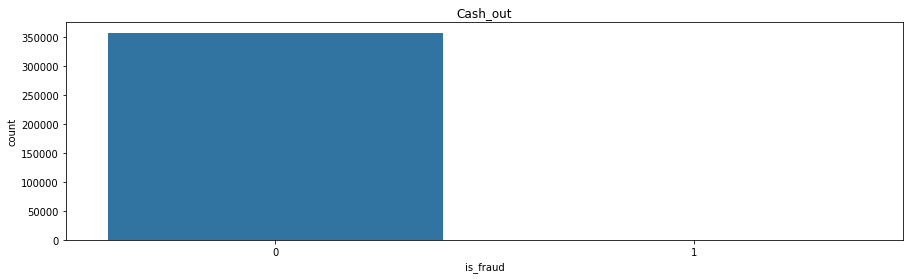

In [83]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(df3[df3['type']=='CASH_OUT']['is_fraud']).set_title('Cash_out')

In [84]:
df3[df3['type']=='CASH_OUT']['is_fraud'].value_counts()

0    357123
1       636
Name: is_fraud, dtype: int64

Hypothesis **TRUE**
- there are 636 fraud's transactions in CASH_OUT type

### 3.2.4 Fraud should not occur in debit type of transaction

Text(0.5, 1.0, 'DEBIT')

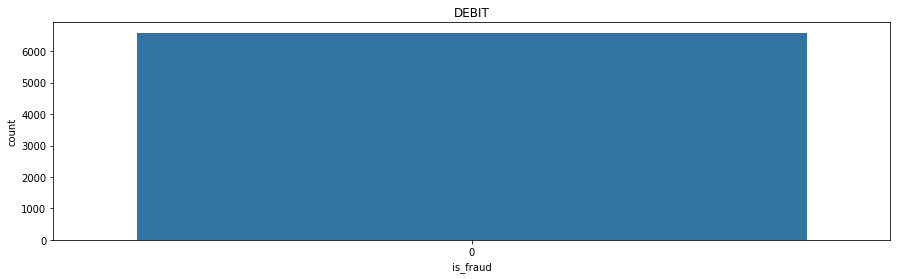

In [85]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(df3[df3['type']=='DEBIT']['is_fraud']).set_title('DEBIT')

In [86]:
df3[df3['type']=='DEBIT']['is_fraud'].value_counts()

0    6582
Name: is_fraud, dtype: int64

Hypothesis **TRUE**
- there are not fraud's transaction in Debit type

### 3.2.5 Fraud should occur when the difference between old balance and new balance is lower than amount (origin)

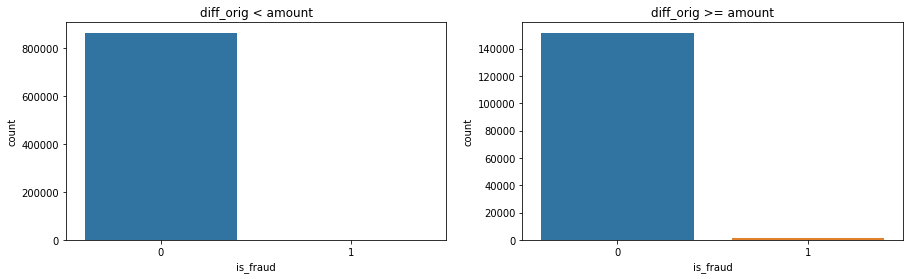

In [87]:
aux5 = df3.copy()
aux5['diff_orig_amount'] = aux5['diff_orig'] - aux5['amount']

aux6 = aux5[aux5['diff_orig_amount']<0][['diff_orig_amount','is_fraud']]
aux7 = aux5[aux5['diff_orig_amount']>=0][['diff_orig_amount','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux6['is_fraud'], ax=axs[0]).set_title('diff_orig < amount')
sns.countplot(aux7['is_fraud'], ax=axs[1]).set_title('diff_orig >= amount');

In [88]:
aux5['diff_orig_amount'] = aux5['diff_orig_amount'].apply(lambda x: 1 if x < 0 else 0)
aux5 = pd.crosstab(aux5['diff_orig_amount'], aux5['is_fraud'])
aux5['percent %'] = aux5[1]*100/(aux5[1]+aux5[0])
aux5

is_fraud,0,1,percent %
diff_orig_amount,,,
0,151620,1305,0.853359
1,865046,9,0.001040


Hypothesis **FALSE**
- 0.853% of diff_orig >= amount is a fraud transaction 
- 0.001% of diff_orig < amount is a fraud transaction 

### 3.2.6 Fraud should not occur when the difference between old balance and new balance is equal to amount (origin)

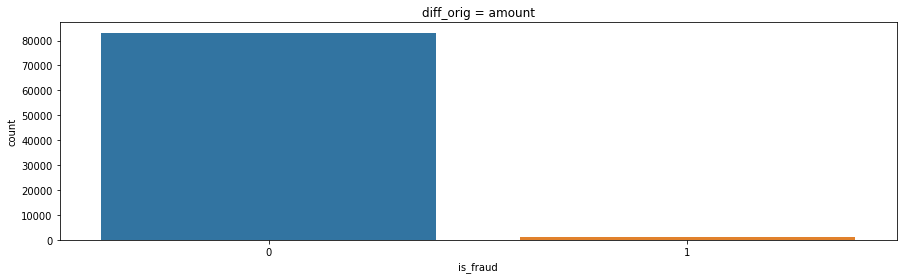

In [89]:
aux8 = df3.copy()
aux8['diff_orig_amount'] = aux8['diff_orig'] - aux8['amount']

aux8 = aux8[aux8['diff_orig_amount']==0][['diff_orig_amount','is_fraud']]

fig= plt.subplots( figsize = (15,4))
sns.countplot(aux8['is_fraud']).set_title('diff_orig = amount');

In [90]:
aux8['is_fraud'].value_counts()

0    83115
1     1302
Name: is_fraud, dtype: int64

Hypothesis **FALSE**
- Fraud occurs when difference between difference origin (newbalance - oldbalance) is equal to amount

### 3.2.7 Fraud should not occur when new balance is equal to 0 (origin)

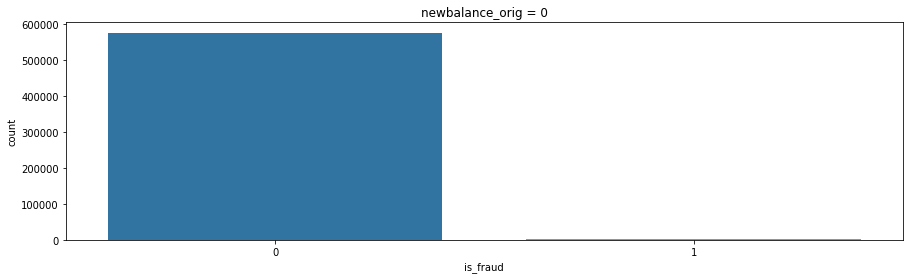

In [91]:
fig= plt.subplots( figsize = (15,4))
sns.countplot(df3[df3['newbalance_orig']==0]['is_fraud']).set_title('newbalance_orig = 0');

In [92]:
df3[df3['newbalance_orig']==0]['is_fraud'].value_counts()

0    575697
1      1288
Name: is_fraud, dtype: int64

In [93]:
df3[df3['newbalance_orig']!=0]['is_fraud'].value_counts()

0    440969
1        26
Name: is_fraud, dtype: int64

Hypothesis **FALSE**
- Fraud occurs when newbalance is equal to zero

### 3.2.8 Fraud should occur when the difference between new balance and old balance is lower than amount (destination)

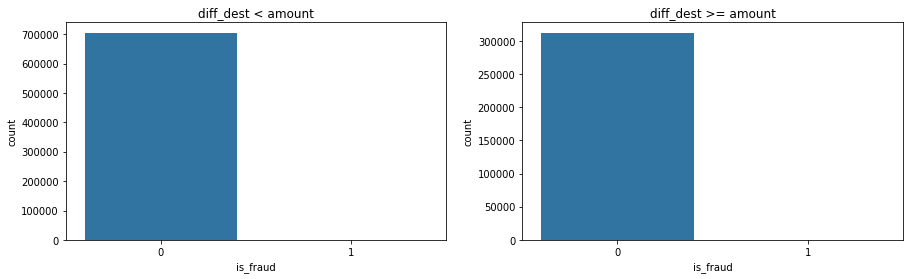

In [94]:
aux9 = df3.copy()
aux9['diff_dest_amount'] = aux9['diff_dest'] - aux9['amount']

aux10 = aux9[aux9['diff_dest_amount']<0][['diff_dest_amount','is_fraud']]
aux11 = aux9[aux9['diff_dest_amount']>=0][['diff_dest_amount','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux10['is_fraud'], ax=axs[0]).set_title('diff_dest < amount')
sns.countplot(aux11['is_fraud'], ax=axs[1]).set_title('diff_dest >= amount');

In [95]:
aux9['diff_dest_amount'] = aux9['diff_dest_amount'].apply(lambda x: 1 if x < 0 else 0)
aux9 = pd.crosstab(aux9['diff_dest_amount'], aux9['is_fraud'])
aux9['percent %'] = aux9[1]*100/(aux9[1]+aux9[0])
aux9

is_fraud,0,1,percent %
diff_dest_amount,,,
0,312132,504,0.161210
1,704534,810,0.114838


Hypothesis **TRUE**
- 0.161% of diff_dest < amount is a fraud transaction 
- 0.115% of diff_dest >= amount is a fraud transaction 

### 3.2.9 Fraud should not occur when the difference between new balance and old balance is equal to amount (destination)

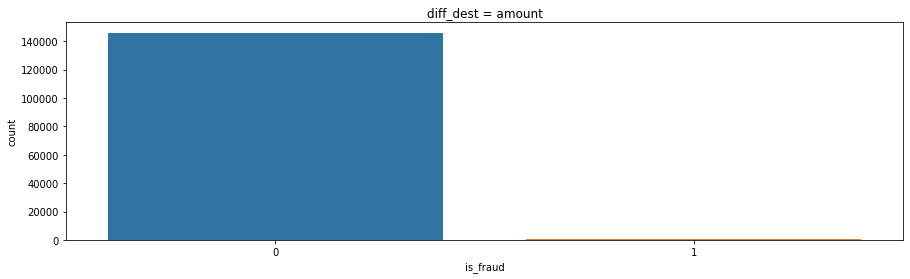

In [96]:
fig = plt.subplots(figsize = (15,4))

sns.countplot(aux11[aux11['diff_dest_amount']==0]['is_fraud']).set_title('diff_dest = amount');

In [97]:
aux11[aux11['diff_dest_amount']==0]['is_fraud'].value_counts()

0    146043
1       355
Name: is_fraud, dtype: int64

Hypothesis **FALSE**
- Fraud occurs when the difference between new balance and old balance (destination) is equal to amount 

### 3.2.10 Fraud should not occur when destination is merchant (destination)

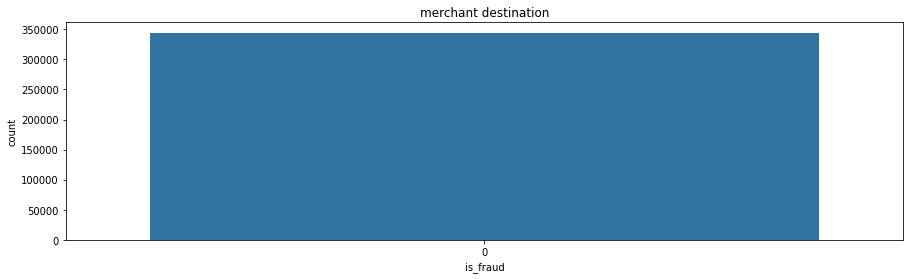

In [98]:
fig = plt.subplots(figsize = (15,4))

sns.countplot(df3[df3['merchant_dest']==1]['is_fraud']).set_title('merchant destination');

In [99]:
df3[df3['merchant_dest']==1]['is_fraud'].value_counts()

0    344058
Name: is_fraud, dtype: int64

Hypothesis **TRUE**
- Fraud does not occur when destination is merchant (destination)

### 3.2.11 Fraud should occur in the beginning of the month (day 1 to day 8)

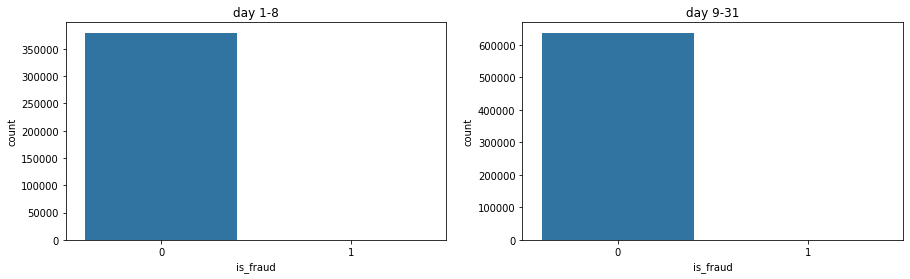

In [100]:
aux12 = df3[df3['day']<9][['day','is_fraud']]
aux13 = df3[df3['day']>=9][['day','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux12['is_fraud'], ax=axs[0]).set_title('day 1-8')
sns.countplot(aux13['is_fraud'], ax=axs[1]).set_title('day 9-31');

In [101]:
aux14 = df3.copy()
aux14['day_beginning'] = aux14['day'].apply(lambda x: 1 if x < 9 else 0)
aux14 = pd.crosstab(aux14['day_beginning'], aux14['is_fraud'])
aux14['percent %'] = aux14[1]*100/(aux14[1]+aux14[0])
aux14

is_fraud,0,1,percent %
day_beginning,,,
0,637113,975,0.152800
1,379553,339,0.089236


Hypothesis **TRUE**
- 0.15% is fraud of day 1 to day 8
- 0.09% is fraud of day 9 to day 31

### 3.2.12 Fraud should occurs during night (6pm to 11h59 pm)

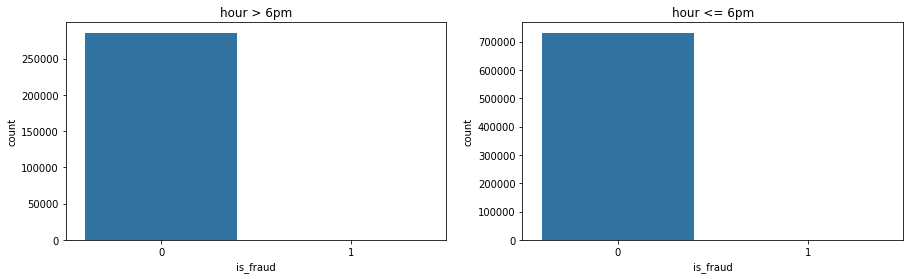

In [102]:
aux15 = df3[df3['hour']>18][['hour','is_fraud']]
aux16 = df3[df3['hour']<=18][['hour','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux15['is_fraud'], ax=axs[0]).set_title('hour > 6pm')
sns.countplot(aux16['is_fraud'], ax=axs[1]).set_title('hour <= 6pm');

In [103]:
aux17 = df3.copy()
aux17['hour_night'] = aux17['hour'].apply(lambda x: 1 if x > 18 else 0)
aux17 = pd.crosstab(aux17['hour_night'], aux17['is_fraud'])
aux17['percent %'] = aux17[1]*100/(aux17[1]+aux17[0])
aux17

is_fraud,0,1,percent %
hour_night,,,
0,730980,1030,0.140708
1,285686,284,0.099311


Hypothesis **FALSE**
- 0.14% is fraud of hour 6pm to midnight
- 0.10% is fraud of hour midnight to 6 pm

## 3.3 Multivariable Analysis

### 3.3.1 Numerical Attributes

In [104]:
df3.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
hour                  int64
day                 float64
diff_orig           float64
diff_dest           float64
merchant_dest         int64
dtype: object

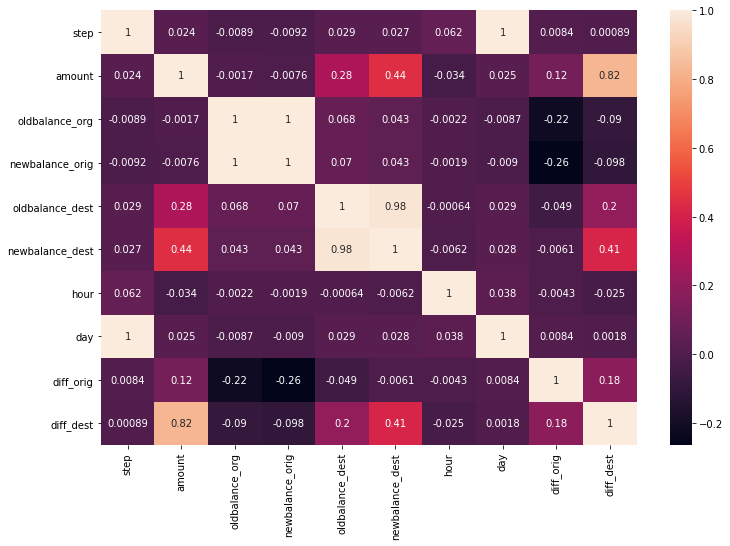

In [105]:
num_attributes = df3.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop(['merchant_dest','is_flagged_fraud','is_fraud'], axis=1)
fig = plt.subplots(figsize = (12,8))
sns.heatmap(num_attributes.corr(), annot = True);

### 3.3.1 Categorical Attributes

In [ ]:
cat_attributes = df3[['merchant_dest','is_flagged_fraud','type','name_orig','name_dest']]
fig = plt.subplots(figsize = (12,8))
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

## 3.4 Hypothesis conclusion 

In [ ]:
hyp_conclu = pd.DataFrame(columns= ['Hypothesis', 'True/False', 'Relevance'])

hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H1 - Fraud should occur in higher value amounts (higher than 200k)', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H2 - Fraud should occur in higher percent amount per origin balance (higher than 75%)', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H3 - Fraud should occur in cash_out type of transaction', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H4 - Fraud should not occur in debit type of transaction', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H5 - Fraud should occur when the difference between old balance and new balance is lower than amount (origin)', 'False', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H6 - Fraud should not occur when the difference between old balance and new balance is equal to amount (origin)', 'False', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H7 - Fraud should not occur when new balance is equal to 0 (origin)', 'False', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H8 - Fraud should occur when the difference between new balance and old balance is lower than amount (destination)', 'False', 'Low'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H9 - Fraud should not occur when the difference between new balance and old balance is equal to amount (destination)', 'False', 'Mid'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H10 - Fraud should not occur when destination is merchant (destination)', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H11 - Fraud should occur in the beginning of the month (day 1 to day 8)', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H12 - Fraud should occurs during night (6pm to 11h59 pm)', 'False', 'Mid'])), ignore_index=True)

pd.set_option('display.max_colwidth', 120)
hyp_conclu

Balancear:
    quebrar dataset em cashin, ficar com 10%
    quebrar dataset em payment, ficar com 10%
    quebrar dataset em debit

In [ ]:
#df2['hour_sen'] = df2['step'].apply( lambda x: np.sin( x%24 * (2. * np.pi/24 ) ) )
#df2['hour_cos'] = df2['step'].apply( lambda x: np.cos( x%24 * (2. * np.pi/24 ) ) )

#df2['day_sen'] = df2['step'].apply( lambda x: np.sin( np.ceil(x / 24)  * (2. * np.pi/31 ) ) )
#df2['day_cos'] = df2['step'].apply( lambda x: np.cos( np.ceil(x / 24)  * (2. * np.pi/31 ) ) )

## New heading